In [1]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

numpy는 유명한 수치해석용 라이브러리.

sklearn은 파이썬의 대표적인 머신러닝 라이브러리로 사실 딥러닝을 제외한 머신러닝은 대부분 sklearn을 이용합니다. 

matplotlib은 시각화를 위해 가져옵니다.

In [2]:
n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim,
                              centers=[[0,0],[1,1],[1,0],[0,1]],
                              shuffle=True, cluster_std=0.15)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim,
                            centers=[[0,0],[1,1],[1,0],[0,1]],
                            shuffle=True, cluster_std=0.15)

make_blobs()를 이용해서 데이터를 2차원 벡터로 만들었습니다. 

80대 20으로만들었습니다. 

make_blobs()함수가 만들어내는 레이블 데이터는 각 데이터 한점 한점이 몇번째 클러스터에 속해있는지 알려주는 인덱스입니다. 

본 예제에서는 4개의 클러스터를 생성하였으므로 이미 0, 1, 2, 3으로 파싱되어 있습니다.

In [3]:
for i, x in enumerate(x_train):
    print(x, y_train[i])
    if i == 15 : break

[0.76963342 0.04336016] 2
[1.0568018  1.11905071] 1
[ 0.75487898 -0.00701441] 2
[1.04896476 1.08085528] 1
[0.11414816 0.90651401] 3
[ 0.79700531 -0.17857101] 2
[1.16508174 1.06614625] 1
[1.09883896 0.21134147] 2
[ 0.97978926 -0.11469192] 2
[ 0.42821888 -0.08159947] 0
[0.02833379 0.18538   ] 0
[ 0.94595967 -0.04697924] 2
[0.95694561 0.89472249] 1
[-0.06806462  0.0769948 ] 0
[0.23360395 1.10975201] 3
[-0.13869731  0.17385993] 0


label을 재설정해주겠습니다. 저희는 Binary Classify를 하기위한 NN을 만들려고 하거든요

In [4]:
def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

따라서 label_map이라는 함수를 하나 구현해서 0번이나 1번을 레이블로 가진 데이터는 전부 0번 레이블을 갖도록 바꿔줍니다. 

그리고 2번이나 3번을 레이블로 가진 데이터는 전부 1번 레이블을 갖도록 바꿔줍니다. 

데이터가 제대로 만들어지고 레이블링 되어있는지 확인하기 위해 시각화를 진행합니다. 0인 데이터는 o, 1인데이터는 +로 표기했습니다.

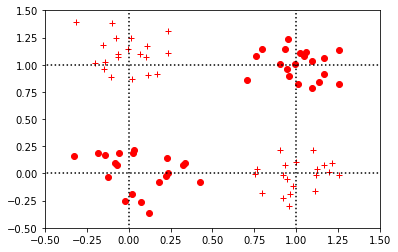

In [5]:
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train, y_train, c='r')
plt.plot([-1, 2], [0,0], linestyle = ":", color = 'k')
plt.plot([-1, 2], [1,1], linestyle = ":", color = 'k')
plt.plot([0, 0], [-1, 2], linestyle = ":", color = 'k')
plt.plot([1, 1], [-1,2], linestyle = ":", color = 'k')
#vis_data(x_test, y_test, c='b')
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.show()

In [6]:
x_train = torch.FloatTensor(x_train)
print(x_train.shape)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

torch.Size([80, 2])


layer 는 여러 노드들이 층으로 모여있는 것을 의미하는데요
여기에는 

In [7]:
class NeuralNet(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(NeuralNet, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            
            self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, input_tensor):
            linear1 = self.linear_1(input_tensor)
            relu = self.relu(linear1)
            
            linear2 = self.linear_2(relu)
            output = self.sigmoid(linear2)
            return output

criterion 은 에러함수를 의미합니다.
교수님께서 아까도 설명하셨지만 지금과같은 B Classify할때는 MSE를 사용하는 것이 적당하지 않습니다. 그래서 저희는 Binary Cross Entropy 를 사용할것인데 이것도 torch에서 제공하고 있습니다.

왜 (2,5)로 했을까?

In [8]:
learning_rate = 0.15
epochs = 2000
model = NeuralNet(2, 5)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

input_size를 2로, hidden_size를 5로 설정한 신경망 객체 model을 만듭니다.

In [9]:
model(torch.tensor([0.1,0.1]))

tensor([0.3733], grad_fn=<SigmoidBackward>)

model의 weight가 어떻게 존재할까요

In [10]:
for a in model.parameters():
    print(a)

Parameter containing:
tensor([[-0.6771,  0.6020],
        [ 0.4320, -0.1697],
        [-0.4429, -0.4841],
        [ 0.4985,  0.6024],
        [ 0.6849,  0.6090]], requires_grad=True)
Parameter containing:
tensor([ 0.5517, -0.0075, -0.5011, -0.6412, -0.5674], requires_grad=True)
Parameter containing:
tensor([[-0.3247, -0.2063, -0.4021,  0.1120,  0.1913]], requires_grad=True)
Parameter containing:
tensor([-0.3376], requires_grad=True)


In [11]:
for a in model.parameters():
    print(a.grad)

None
None
None
None


In [12]:
model.eval()
test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.7588545680046082


아무 학습도 하지 않은 모델의 성능을 시험해 보겠습니다. 

모델의 결과값과 레이블값의 차원을 맞춰야 하므로 squeeze() 함수를 호출한 후 오차를 구했습니다. 

item()함수는 텐서 속의 숫자를 스칼라 값으로 반환합니다. 

test_loss_before 역시 텐서 형태이므로 실제 오차를 스칼라 값으로 출력하기 위해 .item() 함수를 호출하여 텐서 속 오차를 나타내었습니다.

오차가 0.70이 나왔다는 것은, 100번 중 70번은 틀린거나 마찬가지입니다. 성능이 정말 안좋네요.

이제 학습을 해봅시다. epochs만큼 반복하는 for문이고,

모델에 train() 함수를 호출해 학습 모드로 바꿔줍니다. 

epochs마다 새로운 경사값을 계산할 것이므로 zero_grad() 함수를 호출해 경사값을 0으로 설정합니다. 

100epochs마다 오차를 출력해 학습이 잘 되는지 확인할 예정입니다.

In [13]:
model.train()
optimizer.zero_grad()
train_output = model(x_train)
train_loss = criterion(train_output.squeeze(), y_train)
train_loss.backward()
optimizer.step()

In [14]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
        torch.save(model.state_dict(), './model_epoch{}.pt'.format(epoch))
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.7516783475875854
Train loss at 100 is 0.623949408531189
Train loss at 200 is 0.49508070945739746
Train loss at 300 is 0.3575344979763031
Train loss at 400 is 0.2191556990146637
Train loss at 500 is 0.13483020663261414
Train loss at 600 is 0.09196040779352188
Train loss at 700 is 0.06846713274717331
Train loss at 800 is 0.053983502089977264
Train loss at 900 is 0.04429399222135544
Train loss at 1000 is 0.03740605339407921
Train loss at 1100 is 0.032329440116882324
Train loss at 1200 is 0.02845803275704384
Train loss at 1300 is 0.02541850134730339
Train loss at 1400 is 0.022951247170567513
Train loss at 1500 is 0.020908575505018234
Train loss at 1600 is 0.01919066347181797
Train loss at 1700 is 0.017726127058267593
Train loss at 1800 is 0.016462648287415504
Train loss at 1900 is 0.01536152046173811


In [15]:
model.eval()
test_loss = criterion(model(x_test).squeeze(), y_test)
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.01375609077513218


학습 전과 비교해 loss가 현저하게 줄어든 것을 확인할 수 있습니다.

학습된 모델을 state_dict() 함수 형태로 바꾸어 준 후 .pt 파일로 저장해보겠습니다. 

state_dict()함수 형태로 바꾸어 준 후 .pt 파일로 저장 합니다. 

state_dict() 함수는 모델 내 가중치들이 딕셔너리 형태로 표현된 데이터입니다.

In [16]:
torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[-1.8989,  3.4253],
        [ 3.4943, -1.8699],
        [-0.4429, -0.4841],
        [ 1.5004,  1.5400],
        [ 1.4708,  1.5030]])), ('linear_1.bias', tensor([-0.9358, -1.0768, -0.5011, -1.6626, -1.6237])), ('linear_2.weight', tensor([[ 3.8986,  4.0860, -0.4021, -2.5265, -2.4373]])), ('linear_2.bias', tensor([-3.8026]))])


언제든지 이 파일을 읽어서 준비된 가중치를 바로 적용할 수 있습니다.

In [17]:
new_model = NeuralNet(2, 5)
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print('벡터 [0, 1]의 레이블은? {}'.format\
      (new_model(torch.FloatTensor([0,1])).item()))

벡터 [0, 1]의 레이블은? 0.9972755312919617


In [18]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round((y_pred)).squeeze()

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [19]:
new_model.eval()
print(torch.round(new_model(x_test)).squeeze())
print(y_test)
print(binary_acc(new_model(x_test), y_test))

tensor([1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0.], grad_fn=<SqueezeBackward0>)
tensor([1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0.])
tensor(100.)


In [20]:
for i in range(0,2000,100):
    new_model = NeuralNet(2, 5)
    new_model.load_state_dict(torch.load('./model_epoch{}.pt'.format(i)))
    new_model.eval()
    print("======epoch : {} =======".format(i))
    print(binary_acc(new_model(x_test), y_test))

======epoch : 0 =======
tensor(50.)
======epoch : 100 =======
tensor(65.)
======epoch : 200 =======
tensor(75.)
======epoch : 300 =======
tensor(95.)
======epoch : 400 =======
tensor(100.)
======epoch : 500 =======
tensor(100.)
======epoch : 600 =======
tensor(100.)
======epoch : 700 =======
tensor(100.)
======epoch : 800 =======
tensor(100.)
======epoch : 900 =======
tensor(100.)
======epoch : 1000 =======
tensor(100.)
======epoch : 1100 =======
tensor(100.)
======epoch : 1200 =======
tensor(100.)
======epoch : 1300 =======
tensor(100.)
======epoch : 1400 =======
tensor(100.)
======epoch : 1500 =======
tensor(100.)
======epoch : 1600 =======
tensor(100.)
======epoch : 1700 =======
tensor(100.)
======epoch : 1800 =======
tensor(100.)
======epoch : 1900 =======
tensor(100.)
